In [171]:
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p


from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

import xgboost as xgb
import lightgbm as lgb


train_path = "./house-prices-advanced-regression-techniques/train.csv"
test_path ="./house-prices-advanced-regression-techniques/test.csv"

In [172]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
train.head(5)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [173]:
print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


In [174]:
#把id去掉
train_Id = train['Id']
test_Id = test['Id']
train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)
print(train.shape)
print(test.shape)

(1460, 80)
(1459, 79)


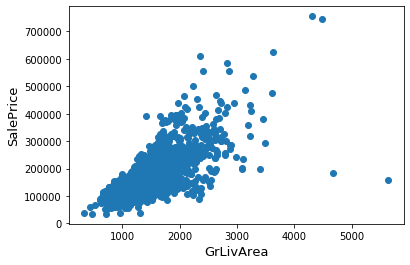

In [116]:
# 處理前數據的分佈, 加x,y軸Label
fig, ax = plt.subplots()
ax.scatter(x=train['GrLivArea'], y=train['SalePrice'])
plt.xlabel('GrLivArea', fontsize=13)
plt.ylabel('SalePrice', fontsize=13)

plt.show()


In [175]:
# 刪掉下面兩個異常數據 (train['GrLivArea']>4000) & (train['SalePrice']<300000)
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)


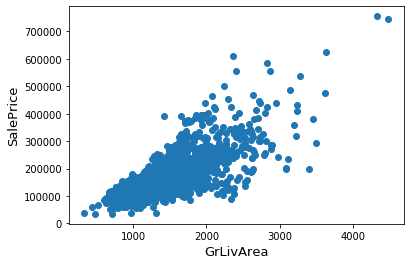

In [176]:
# 處理後數據的分佈, 加x,y軸Label
fig, ax = plt.subplots()
ax.scatter(x=train['GrLivArea'], y=train['SalePrice'])
plt.xlabel('GrLivArea', fontsize=13)
plt.ylabel('SalePrice', fontsize=13)

plt.show()

In [8]:
#SalePrice特徵處理


 mu=180932.92 and sigma=79467.79 



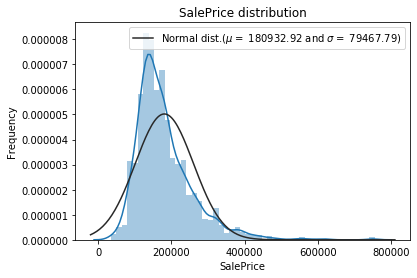

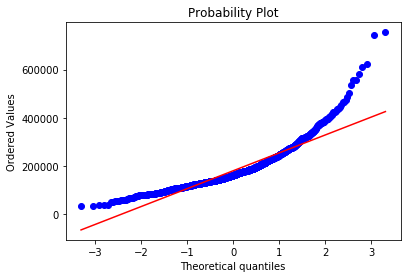

In [177]:
# 處理前數據的分佈, 加x,y軸Label

sns.distplot(train['SalePrice'], fit=norm)
(mu, sigma) = norm.fit(train['SalePrice'])
print('\n mu={:.2f} and sigma={:.2f} \n'.format(mu, sigma))
#下圖表標注
plt.legend(['Normal dist.($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')


fig = plt.figure()
stats.probplot(train['SalePrice'], plot=plt)
plt.show()





In [ ]:
# 數據的偏度大, 用log1p處理(log(X+1)), 使其更加服從高斯分佈。
# 最後需要將預測出的平滑數據進行還原，而還原過程就是log1p的逆運算expm1

In [178]:
train['SalePrice'] = np.log1p(train['SalePrice'])


 mu=12.02 and sigma=0.40 



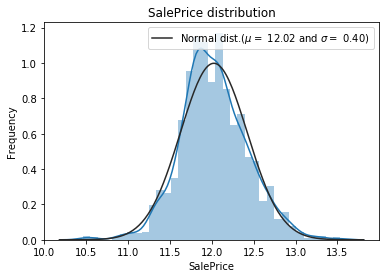

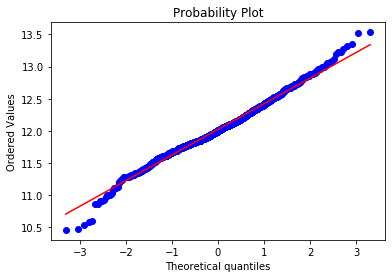

In [179]:
# 處理後數據的分佈, 加x,y軸Label

sns.distplot(train['SalePrice'], fit=norm)
(mu, sigma) = norm.fit(train['SalePrice'])
print('\n mu={:.2f} and sigma={:.2f} \n'.format(mu, sigma))
#下圖表標注
plt.legend(['Normal dist.($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')


fig = plt.figure()
stats.probplot(train['SalePrice'], plot=plt)
plt.show()





In [ ]:
特徵處理


In [180]:
#數據集連接
ntrain = train.shape[0]
ntest = train.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print('all_data size is {}'.format(all_data.shape))

all_data size is (2917, 79)


In [ ]:
#數值缺失分析

In [181]:
all_data.isnull().head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,CentralAir,Condition1,Condition2,Electrical,EnclosedPorch,ExterCond,ExterQual,Exterior1st,Exterior2nd,Fence,FireplaceQu,Fireplaces,Foundation,FullBath,Functional,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,GrLivArea,HalfBath,Heating,HeatingQC,HouseStyle,KitchenAbvGr,KitchenQual,LandContour,LandSlope,LotArea,LotConfig,LotFrontage,LotShape,LowQualFinSF,MSSubClass,MSZoning,MasVnrArea,MasVnrType,MiscFeature,MiscVal,MoSold,Neighborhood,OpenPorchSF,OverallCond,OverallQual,PavedDrive,PoolArea,PoolQC,RoofMatl,RoofStyle,SaleCondition,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False


In [182]:
all_data.isnull().sum().head()

1stFlrSF           0
2ndFlrSF           0
3SsnPorch          0
Alley           2719
BedroomAbvGr       0
dtype: int64

In [183]:
all_data_na = (all_data.isnull().sum()/len(all_data))*100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' : all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
FireplaceQu,48.680151
LotFrontage,16.660953
GarageQual,5.450806
GarageCond,5.450806
GarageFinish,5.450806
GarageYrBlt,5.450806


Text(0.5, 1.0, 'Percent missing data by feature')

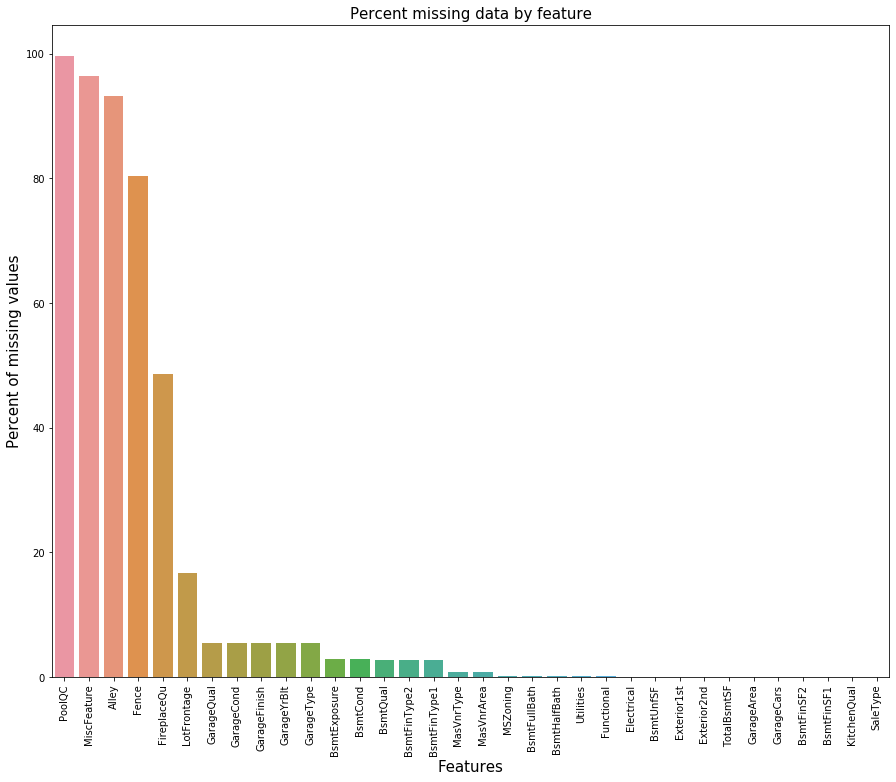

In [184]:

# 含有缺失值的特徵的缺失率

f, axis = plt.subplots(figsize=(15,12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [ ]:

數據相關性

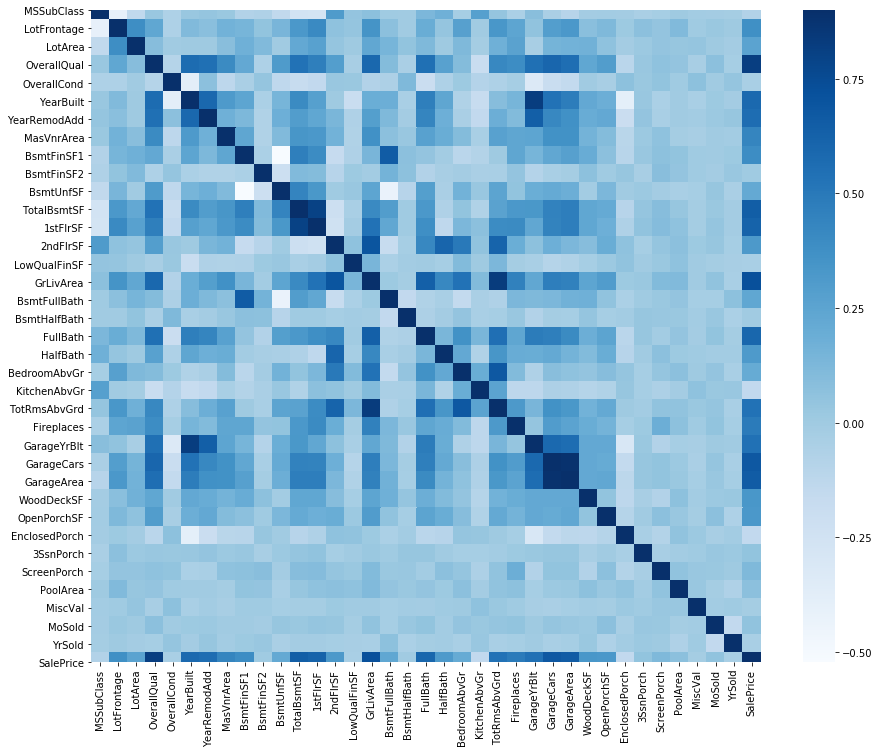

In [185]:
# 全部數值特徵


corrmat = train.corr()
plt.subplots(figsize=(15,12))
sns.heatmap(corrmat, vmax=0.9, cmap='Blues', square=True)

In [42]:
# sns.heatmap(cm, cbar=True, annot=True, cmap='Blues', square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)


In [ ]:
# 相關性最大的10個特徵


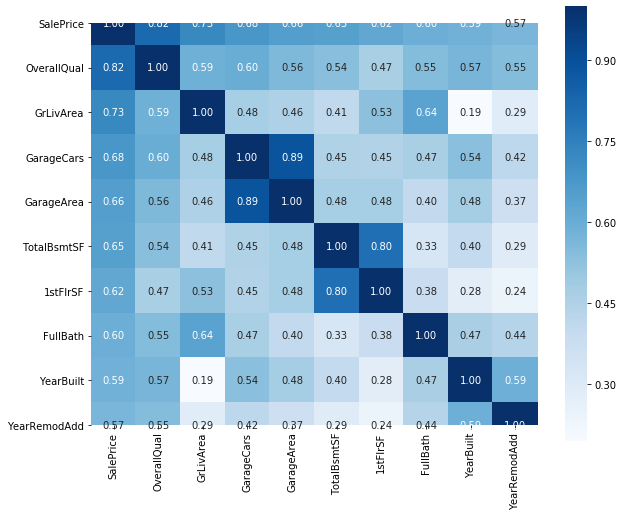

In [186]:
corrmat = train.corr()
plt.subplots(figsize=(10,8))
k = 10
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.heatmap(cm, cbar=True, cmap='Blues', annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)


In [187]:
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' : all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
FireplaceQu,48.680151
LotFrontage,16.660953
GarageQual,5.450806
GarageCond,5.450806
GarageFinish,5.450806
GarageYrBlt,5.450806


In [ ]:
#缺失值填充

In [188]:
all_data.head(10)

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,CentralAir,Condition1,Condition2,Electrical,EnclosedPorch,ExterCond,ExterQual,Exterior1st,Exterior2nd,Fence,FireplaceQu,Fireplaces,Foundation,FullBath,Functional,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,GrLivArea,HalfBath,Heating,HeatingQC,HouseStyle,KitchenAbvGr,KitchenQual,LandContour,LandSlope,LotArea,LotConfig,LotFrontage,LotShape,LowQualFinSF,MSSubClass,MSZoning,MasVnrArea,MasVnrType,MiscFeature,MiscVal,MoSold,Neighborhood,OpenPorchSF,OverallCond,OverallQual,PavedDrive,PoolArea,PoolQC,RoofMatl,RoofStyle,SaleCondition,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,GLQ,Unf,1.0,0.0,Gd,150.0,Y,Norm,Norm,SBrkr,0,TA,Gd,VinylSd,VinylSd,NaN,NaN,0,PConc,2,Typ,548.0,2.0,TA,RFn,TA,Attchd,2003.0,1710,1,GasA,Ex,2Story,1,Gd,Lvl,Gtl,8450,Inside,65.0,Reg,0,60,RL,196.0,BrkFace,NaN,0,2,CollgCr,61,5,7,Y,0,NaN,CompShg,Gable,Normal,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,ALQ,Unf,0.0,1.0,Gd,284.0,Y,Feedr,Norm,SBrkr,0,TA,TA,MetalSd,MetalSd,NaN,TA,1,CBlock,2,Typ,460.0,2.0,TA,RFn,TA,Attchd,1976.0,1262,0,GasA,Ex,1Story,1,TA,Lvl,Gtl,9600,FR2,80.0,Reg,0,20,RL,0.0,None,NaN,0,5,Veenker,0,8,6,Y,0,NaN,CompShg,Gable,Normal,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,GLQ,Unf,1.0,0.0,Gd,434.0,Y,Norm,Norm,SBrkr,0,TA,Gd,VinylSd,VinylSd,NaN,TA,1,PConc,2,Typ,608.0,2.0,TA,RFn,TA,Attchd,2001.0,1786,1,GasA,Ex,2Story,1,Gd,Lvl,Gtl,11250,Inside,68.0,IR1,0,60,RL,162.0,BrkFace,NaN,0,9,CollgCr,42,5,7,Y,0,NaN,CompShg,Gable,Normal,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
3,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,ALQ,Unf,1.0,0.0,TA,540.0,Y,Norm,Norm,SBrkr,272,TA,TA,Wd Sdng,Wd Shng,NaN,Gd,1,BrkTil,1,Typ,642.0,3.0,TA,Unf,TA,Detchd,1998.0,1717,0,GasA,Gd,2Story,1,Gd,Lvl,Gtl,9550,Corner,60.0,IR1,0,70,RL,0.0,None,NaN,0,2,Crawfor,35,5,7,Y,0,NaN,CompShg,Gable,Abnorml,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
4,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,GLQ,Unf,1.0,0.0,Gd,490.0,Y,Norm,Norm,SBrkr,0,TA,Gd,VinylSd,VinylSd,NaN,TA,1,PConc,2,Typ,836.0,3.0,TA,RFn,TA,Attchd,2000.0,2198,1,GasA,Ex,2Story,1,Gd,Lvl,Gtl,14260,FR2,84.0,IR1,0,60,RL,350.0,BrkFace,NaN,0,12,NoRidge,84,5,8,Y,0,NaN,CompShg,Gable,Normal,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008
5,796,566,320,NaN,1,1Fam,TA,No,732.0,0.0,GLQ,Unf,1.0,0.0,Gd,64.0,Y,Norm,Norm,SBrkr,0,TA,TA,VinylSd,VinylSd,MnPrv,NaN,0,Wood,1,Typ,480.0,2.0,TA,Unf,TA,Attchd,1993.0,1362,1,GasA,Ex,1.5Fin,1,TA,Lvl,Gtl,14115,Inside,85.0,IR1,0,50,RL,0.0,None,Shed,700,10,Mitchel,30,5,5,Y,0,NaN,CompShg,Gable,Normal,WD,0,Pave,5,796.0,AllPub,40,1993,1995,2009
6,1694,0,0,NaN,3,1Fam,TA,Av,1369.0,0.0,GLQ,Unf,1.0,0.0,Ex,317.0,Y,Norm,Norm,SBrkr,0,TA,Gd,VinylSd,VinylSd,NaN,Gd,1,PConc,2,Typ,636.0,2.0,TA,RFn,TA,Attchd,2004.0,1694,0,GasA,Ex,1Story,1,Gd,Lvl,Gtl,10084,Inside,75.0,Reg,0,20,RL,186.0,Stone,NaN,0,8,Somerst,57,5,8,Y,0,NaN,CompShg,Gable,Normal,WD,0,Pave,7,1686.0,AllPub,255,2004,2005,2007
7,1107,983,0,NaN,3,1Fam,TA,Mn,859.0,32.0,ALQ,BLQ,1.0,0.0,Gd,216.0,Y,PosN,Norm,SBrkr,228,TA,TA,HdBoard,HdBoard,NaN,TA,2,CBlock,2,Typ,484.0,2.0,TA,RFn,TA,Attchd,1973.0,2090,1,GasA,Ex,2Story,1,TA,Lvl,Gtl,10382,Corner,NaN,IR1,0,60,RL,240.0,Stone,Shed,350,11,NWAmes,204,6,7,Y,0,NaN,CompShg,Gable,Normal,WD,0,Pave,7,1107.0,AllPub,235,1973,1973,2009
8,1022,752,0,NaN,2,1Fam,TA,No,0.0,0.0,Unf,Unf,0.0,0.0,TA,952.0,Y,Artery,Norm,FuseF,205,TA,TA,BrkFace,Wd Shng,NaN,TA,2,BrkTil,2,Min1,468.0,2.0,TA,Unf,Fa,Detchd,1931.0,1774,0,GasA,Gd,1.5Fin,2,TA,Lvl,Gtl,6120,Inside,51.0,Reg,0,50,RM,0.0,None,NaN,0,4,OldTown,0,5,7,Y,0,NaN,CompShg,Gable,Abnorml,WD,0,Pave,8,952.0,AllPub,90,1931,1950,2008
9,1077,0,0,NaN,2,2fmCon,TA,No,851.0,0.0,GLQ,Unf,1.0,0.0,TA,140.0,Y,Artery,Artery,SBrkr,0,TA,TA,MetalSd,MetalSd,NaN,TA,2,BrkTil,1,Typ,205.0,1.0,

In [189]:
#根據每個特徵的現實含義, 填充合適的值
f1 =  ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 
            'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 
            'BsmtExposure','BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'MSSubClass']

f2 = ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 
            'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea']

f3 = ['MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType']

for i in f1:
    all_data[i] = all_data[i].fillna('None')

for i in f2:
    all_data[i] = all_data[i].fillna(0)

for i in f3:
    all_data[i] = all_data[i].fillna(all_data[i].mode()[0])

all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
all_data = all_data.drop(['Utilities'], axis=1)
all_data['Functional'] = all_data['Functional'].fillna('Typ')



In [190]:
#檢查填充完的值還有沒有缺失

all_data_na = (all_data.isnull().sum()/len(all_data))*100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
miss_data = pd.DataFrame({'Missing Ration' : all_data_na})
miss_data.head()

,Missing Ration


In [191]:
#檢查待編碼的特徵情況
cols = ['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 'ExterQual', 'ExterCond',
        'HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 'BsmtFinType2', 'Functional', 'Fence',
        'BsmtExposure', 'GarageFinish', 'LandSlope', 'LotShape', 'PavedDrive', 'Street', 'Alley',
        'CentralAir', 'MSSubClass', 'OverallCond', 'YrSold', 'MoSold']
all_data[cols].head()
# all_data[cols]['FireplaceQu']


,FireplaceQu,BsmtQual,BsmtCond,GarageQual,GarageCond,ExterQual,ExterCond,HeatingQC,PoolQC,KitchenQual,BsmtFinType1,BsmtFinType2,Functional,Fence,BsmtExposure,GarageFinish,LandSlope,LotShape,PavedDrive,Street,Alley,CentralAir,MSSubClass,OverallCond,YrSold,MoSold
0,None,Gd,TA,TA,TA,Gd,TA,Ex,None,Gd,GLQ,Unf,Typ,None,No,RFn,Gtl,Reg,Y,Pave,None,Y,60,5,2008,2
1,TA,Gd,TA,TA,TA,TA,TA,Ex,None,TA,ALQ,Unf,Typ,None,Gd,RFn,Gtl,Reg,Y,Pave,None,Y,20,8,2007,5
2,TA,Gd,TA,TA,TA,Gd,TA,Ex,None,Gd,GLQ,Unf,Typ,None,Mn,RFn,Gtl,IR1,Y,Pave,None,Y,60,5,2008,9
3,Gd,TA,Gd,TA,TA,TA,TA,Gd,None,Gd,ALQ,Unf,Typ,None,No,Unf,Gtl,IR1,Y,Pave,None,Y,70,5,2006,2
4,TA,Gd,TA,TA,TA,Gd,TA,Ex,None,Gd,GLQ,Unf,Typ,None,Av,RFn,Gtl,IR1,Y,Pave,None,Y,60,5,2008,12


In [192]:
all_data[cols]['MSSubClass']


0        60
1        20
2        60
3        70
4        60
       ... 
2912    160
2913    160
2914     20
2915     85
2916     60
Name: MSSubClass, Length: 2917, dtype: int64

In [193]:
#將數值類型轉化為字符串類型
feature = ['MSSubClass', 'OverallCond', 'YrSold', 'MoSold']
for i in feature:
    all_data[i] = all_data[i].astype(str)


In [138]:
# 標籤編碼對不連續的數字或者文本進行編號, 轉換呈連續的數值型態變量
for c in cols:
    le = LabelEncoder()
    le.fit(list(all_data[c].values))
    all_data[c] = le.transform(list(all_data[c].values))

In [139]:
print('Shape all_data: {}'.format(all_data.shape))
#編碼後的特徵
all_data[cols].head()


Shape all_data: (2917, 78)


,FireplaceQu,BsmtQual,BsmtCond,GarageQual,GarageCond,ExterQual,ExterCond,HeatingQC,PoolQC,KitchenQual,BsmtFinType1,BsmtFinType2,Functional,Fence,BsmtExposure,GarageFinish,LandSlope,LotShape,PavedDrive,Street,Alley,CentralAir,MSSubClass,OverallCond,YrSold,MoSold
0,3,2,4,5,5,2,4,0,3,2,2,6,6,4,3,2,0,3,2,1,1,1,10,4,2,4
1,5,2,4,5,5,3,4,0,3,3,0,6,6,4,1,2,0,3,2,1,1,1,5,7,1,7
2,5,2,4,5,5,2,4,0,3,2,2,6,6,4,2,2,0,0,2,1,1,1,10,4,2,11
3,2,4,1,5,5,3,4,2,3,2,0,6,6,4,3,3,0,0,2,1,1,1,11,4,0,4
4,5,2,4,5,5,2,4,0,3,2,2,6,6,4,0,2,0,0,2,1,1,1,10,4,2,3


In [194]:
pd.set_option('max_columns', 80)
all_data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,CentralAir,Condition1,Condition2,Electrical,EnclosedPorch,ExterCond,ExterQual,Exterior1st,Exterior2nd,Fence,FireplaceQu,Fireplaces,Foundation,FullBath,Functional,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,GrLivArea,HalfBath,Heating,HeatingQC,HouseStyle,KitchenAbvGr,KitchenQual,LandContour,LandSlope,LotArea,LotConfig,LotFrontage,LotShape,LowQualFinSF,MSSubClass,MSZoning,MasVnrArea,MasVnrType,MiscFeature,MiscVal,MoSold,Neighborhood,OpenPorchSF,OverallCond,OverallQual,PavedDrive,PoolArea,PoolQC,RoofMatl,RoofStyle,SaleCondition,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,None,3,1Fam,TA,No,706.0,0.0,GLQ,Unf,1.0,0.0,Gd,150.0,Y,Norm,Norm,SBrkr,0,TA,Gd,VinylSd,VinylSd,None,None,0,PConc,2,Typ,548.0,2.0,TA,RFn,TA,Attchd,2003.0,1710,1,GasA,Ex,2Story,1,Gd,Lvl,Gtl,8450,Inside,65.0,Reg,0,60,RL,196.0,BrkFace,None,0,2,CollgCr,61,5,7,Y,0,None,CompShg,Gable,Normal,WD,0,Pave,8,856.0,0,2003,2003,2008
1,1262,0,0,None,3,1Fam,TA,Gd,978.0,0.0,ALQ,Unf,0.0,1.0,Gd,284.0,Y,Feedr,Norm,SBrkr,0,TA,TA,MetalSd,MetalSd,None,TA,1,CBlock,2,Typ,460.0,2.0,TA,RFn,TA,Attchd,1976.0,1262,0,GasA,Ex,1Story,1,TA,Lvl,Gtl,9600,FR2,80.0,Reg,0,20,RL,0.0,None,None,0,5,Veenker,0,8,6,Y,0,None,CompShg,Gable,Normal,WD,0,Pave,6,1262.0,298,1976,1976,2007
2,920,866,0,None,3,1Fam,TA,Mn,486.0,0.0,GLQ,Unf,1.0,0.0,Gd,434.0,Y,Norm,Norm,SBrkr,0,TA,Gd,VinylSd,VinylSd,None,TA,1,PConc,2,Typ,608.0,2.0,TA,RFn,TA,Attchd,2001.0,1786,1,GasA,Ex,2Story,1,Gd,Lvl,Gtl,11250,Inside,68.0,IR1,0,60,RL,162.0,BrkFace,None,0,9,CollgCr,42,5,7,Y,0,None,CompShg,Gable,Normal,WD,0,Pave,6,920.0,0,2001,2002,2008
3,961,756,0,None,3,1Fam,Gd,No,216.0,0.0,ALQ,Unf,1.0,0.0,TA,540.0,Y,Norm,Norm,SBrkr,272,TA,TA,Wd Sdng,Wd Shng,None,Gd,1,BrkTil,1,Typ,642.0,3.0,TA,Unf,TA,Detchd,1998.0,1717,0,GasA,Gd,2Story,1,Gd,Lvl,Gtl,9550,Corner,60.0,IR1,0,70,RL,0.0,None,None,0,2,Crawfor,35,5,7,Y,0,None,CompShg,Gable,Abnorml,WD,0,Pave,7,756.0,0,1915,1970,2006
4,1145,1053,0,None,4,1Fam,TA,Av,655.0,0.0,GLQ,Unf,1.0,0.0,Gd,490.0,Y,Norm,Norm,SBrkr,0,TA,Gd,VinylSd,VinylSd,None,TA,1,PConc,2,Typ,836.0,3.0,TA,RFn,TA,Attchd,2000.0,2198,1,GasA,Ex,2Story,1,Gd,Lvl,Gtl,14260,FR2,84.0,IR1,0,60,RL,350.0,BrkFace,None,0,12,NoRidge,84,5,8,Y,0,None,CompShg,Gable,Normal,WD,0,Pave,9,1145.0,192,2000,2000,2008


In [195]:
# 創造一個新特徵 = TotalBsmtSF + 1stFlrSF + 2ndFlrSF
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']


print('Shape all_data: {}'.format(all_data.shape))


Shape all_data: (2917, 79)


In [196]:
all_data['TotalSF']

0       2566.0
1       2524.0
2       2706.0
3       2473.0
4       3343.0
         ...  
2912    1638.0
2913    1638.0
2914    2448.0
2915    1882.0
2916    2996.0
Name: TotalSF, Length: 2917, dtype: float64

In [197]:
#倾斜特徵
all_data.dtypes.head(10)


1stFlrSF          int64
2ndFlrSF          int64
3SsnPorch         int64
Alley            object
BedroomAbvGr      int64
BldgType         object
BsmtCond         object
BsmtExposure     object
BsmtFinSF1      float64
BsmtFinSF2      float64
dtype: object

In [198]:
all_data.dtypes[all_data.dtypes != 'object'].index


Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF',
       'EnclosedPorch', 'Fireplaces', 'FullBath', 'GarageArea', 'GarageCars',
       'GarageYrBlt', 'GrLivArea', 'HalfBath', 'KitchenAbvGr', 'LotArea',
       'LotFrontage', 'LowQualFinSF', 'MasVnrArea', 'MiscVal', 'OpenPorchSF',
       'OverallQual', 'PoolArea', 'ScreenPorch', 'TotRmsAbvGrd', 'TotalBsmtSF',
       'WoodDeckSF', 'YearBuilt', 'YearRemodAdd', 'TotalSF'],
      dtype='object')

In [200]:
#計算特徵偏度

numeric_feats = all_data.dtypes[all_data.dtypes != 'object'].index
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew':skewed_feats})
skewness.head(10)

,Skew
PoolArea,15.759529
3SsnPorch,8.921650
LowQualFinSF,8.741030
MiscVal,5.594963
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101
BsmtHalfBath,3.929996
MasVnrArea,2.621719


In [201]:
# 對偏態分佈的數據進行標準化處理，使其更加服從正態分佈

skewness = skewness[abs(skewness) > 0.75]
print('There are {} skewed numerical features to Box Cox transform'.format(skewness.shape[0]))

skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)
    


There are 33 skewed numerical features to Box Cox transform


In [202]:
all_data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,CentralAir,Condition1,Condition2,Electrical,EnclosedPorch,ExterCond,ExterQual,Exterior1st,Exterior2nd,Fence,FireplaceQu,Fireplaces,Foundation,FullBath,Functional,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,GrLivArea,HalfBath,Heating,HeatingQC,HouseStyle,KitchenAbvGr,KitchenQual,LandContour,LandSlope,LotArea,LotConfig,LotFrontage,LotShape,LowQualFinSF,MSSubClass,MSZoning,MasVnrArea,MasVnrType,MiscFeature,MiscVal,MoSold,Neighborhood,OpenPorchSF,OverallCond,OverallQual,PavedDrive,PoolArea,PoolQC,RoofMatl,RoofStyle,SaleCondition,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,TotalSF
0,11.692623,11.686189,0.0,None,1.540963,1Fam,TA,No,11.170327,0.0,GLQ,Unf,0.730463,0.000000,Gd,7.483296,Y,Norm,Norm,SBrkr,0.000000,TA,Gd,VinylSd,VinylSd,None,None,0.000000,PConc,1.194318,Typ,10.506271,1.194318,TA,RFn,TA,Attchd,14.187527,13.698888,0.730463,GasA,Ex,2Story,0.730463,Gd,Lvl,Gtl,3.798610,Inside,5.831328,Reg,0.0,60,RL,8.059126,BrkFace,None,0.0,2,CollgCr,5.714669,5,2.440268,Y,0.0,None,CompShg,Gable,Normal,WD,0.0,Pave,2.602594,11.692623,0.000000,14.187527,14.187527,2008,14.976591
1,12.792276,0.000000,0.0,None,1.540963,1Fam,TA,Gd,12.062832,0.0,ALQ,Unf,0.000000,0.730463,Gd,8.897844,Y,Feedr,Norm,SBrkr,0.000000,TA,TA,MetalSd,MetalSd,None,TA,0.730463,CBlock,1.194318,Typ,10.062098,1.194318,TA,RFn,TA,Attchd,14.145138,12.792276,0.000000,GasA,Ex,1Story,0.730463,TA,Lvl,Gtl,3.837043,FR2,6.221214,Reg,0.0,20,RL,0.000000,None,None,0.0,5,Veenker,0.000000,8,2.259674,Y,0.0,None,CompShg,Gable,Normal,WD,0.0,Pave,2.259674,12.792276,9.010206,14.145138,14.145138,2007,14.923100
2,11.892039,11.724598,0.0,None,1.540963,1Fam,TA,Mn,10.200343,0.0,GLQ,Unf,0.730463,0.000000,Gd,9.917060,Y,Norm,Norm,SBrkr,0.000000,TA,Gd,VinylSd,VinylSd,None,TA,0.730463,PConc,1.194318,Typ,10.775536,1.194318,TA,RFn,TA,Attchd,14.184404,13.832085,0.730463,GasA,Ex,2Story,0.730463,Gd,Lvl,Gtl,3.884731,Inside,5.914940,IR1,0.0,60,RL,7.646538,BrkFace,None,0.0,9,CollgCr,5.053371,5,2.440268,Y,0.0,None,CompShg,Gable,Normal,WD,0.0,Pave,2.259674,11.892039,0.000000,14.184404,14.185966,2008,15.149678
3,12.013683,11.354094,0.0,None,1.540963,1Fam,Gd,No,8.274266,0.0,ALQ,Unf,0.730463,0.000000,TA,10.468500,Y,Norm,Norm,SBrkr,8.797736,TA,TA,Wd Sdng,Wd Shng,None,Gd,0.730463,BrkTil,0.730463,Typ,10.918253,1.540963,TA,Unf,TA,Detchd,14.179714,13.711364,0.000000,GasA,Gd,2Story,0.730463,Gd,Lvl,Gtl,3.835471,Corner,5.684507,IR1,0.0,70,RL,0.000000,None,None,0.0,2,Crawfor,4.745132,5,2.440268,Y,0.0,None,CompShg,Gable,Abnorml,WD,0.0,Pave,2.440268,11.354094,0.000000,14.047529,14.135652,2006,14.857121
4,12.510588,12.271365,0.0,None,1.820334,1Fam,TA,Av,10.971129,0.0,GLQ,Unf,0.730463,0.000000,Gd,10.221051,Y,Norm,Norm,SBrkr,0.000000,TA,Gd,VinylSd,VinylSd,None,TA,0.730463,PConc,1.194318,Typ,11.627708,1.540963,TA,RFn,TA,Attchd,14.182841,14.480029,0.730463,GasA,Ex,2Story,0.730463,Gd,Lvl,Gtl,3.955862,FR2,6.314735,IR1,0.0,60,RL,9.391827,BrkFace,None,0.0,12,NoRidge,6.314735,5,2.602594,Y,0.0,None,CompShg,Gable,Normal,WD,0.0,Pave,2.750250,12.510588,8.013884,14.182841,14.182841,2008,15.852312


In [203]:
# 獨熱編碼用來解決類別型數據的離散值問題

all_data = pd.get_dummies(all_data)
all_data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,Fireplaces,FullBath,GarageArea,GarageCars,GarageYrBlt,GrLivArea,HalfBath,KitchenAbvGr,LotArea,LotFrontage,LowQualFinSF,MasVnrArea,MiscVal,OpenPorchSF,OverallQual,PoolArea,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,TotalSF,Alley_Grvl,Alley_None,Alley_Pave,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,...,PavedDrive_Y,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,PoolQC_None,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Street_Grvl,Street_Pave,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010
0,11.692623,11.686189,0.0,1.540963,11.170327,0.0,0.730463,0.000000,7.483296,0.000000,0.000000,1.194318,10.506271,1.194318,14.187527,13.698888,0.730463,0.730463,3.798610,5.831328,0.0,8.059126,0.0,5.714669,2.440268,0.0,0.0,2.602594,11.692623,0.000000,14.187527,14.187527,14.976591,0,1,0,1,0,0,0,...,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0
1,12.792276,0.000000,0.0,1.540963,12.062832,0.0,0.000000,0.730463,8.897844,0.000000,0.730463,1.194318,10.062098,1.194318,14.145138,12.792276,0.000000,0.730463,3.837043,6.221214,0.0,0.000000,0.0,0.000000,2.259674,0.0,0.0,2.259674,12.792276,9.010206,14.145138,14.145138,14.923100,0,1,0,1,0,0,0,...,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0
2,11.892039,11.724598,0.0,1.540963,10.200343,0.0,0.730463,0.000000,9.917060,0.000000,0.730463,1.194318,10.775536,1.194318,14.184404,13.832085,0.730463,0.730463,3.884731,5.914940,0.0,7.646538,0.0,5.053371,2.440268,0.0,0.0,2.259674,11.892039,0.000000,14.184404,14.185966,15.149678,0,1,0,1,0,0,0,...,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0
3,12.013683,11.354094,0.0,1.540963,8.274266,0.0,0.730463,0.000000,10.468500,8.797736,0.730463,0.730463,10.918253,1.540963,14.179714,13.711364,0.000000,0.730463,3.835471,5.684507,0.0,0.000000,0.0,4.745132,2.440268,0.0,0.0,2.440268,11.354094,0.000000,14.047529,14.135652,14.857121,0,1,0,1,0,0,0,...,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0
4,12.510588,12.271365,0.0,1.820334,10.971129,0.0,0.730463,0.000000,10.221051,0.000000,0.730463,1.194318,11.627708,1.540963,14.182841,14.480029,0.730463,0.730463,3.955862,6.314735,0.0,9.391827,0.0,6.314735,2.602594,0.0,0.0,2.750250,12.510588,8.013884,14.182841,14.182841,15.852312,0,1,0,1,0,0,0,...,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0


In [204]:
#重新劃分數據資料

train = all_data[:ntrain]
test = all_data[ntrain:]

In [205]:
print(train.shape)
print(test.shape)
train.head(5)



(1458, 338)
(1459, 338)


,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,Fireplaces,FullBath,GarageArea,GarageCars,GarageYrBlt,GrLivArea,HalfBath,KitchenAbvGr,LotArea,LotFrontage,LowQualFinSF,MasVnrArea,MiscVal,OpenPorchSF,OverallQual,PoolArea,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,TotalSF,Alley_Grvl,Alley_None,Alley_Pave,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,...,PavedDrive_Y,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,PoolQC_None,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Street_Grvl,Street_Pave,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010
0,11.692623,11.686189,0.0,1.540963,11.170327,0.0,0.730463,0.000000,7.483296,0.000000,0.000000,1.194318,10.506271,1.194318,14.187527,13.698888,0.730463,0.730463,3.798610,5.831328,0.0,8.059126,0.0,5.714669,2.440268,0.0,0.0,2.602594,11.692623,0.000000,14.187527,14.187527,14.976591,0,1,0,1,0,0,0,...,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0
1,12.792276,0.000000,0.0,1.540963,12.062832,0.0,0.000000,0.730463,8.897844,0.000000,0.730463,1.194318,10.062098,1.194318,14.145138,12.792276,0.000000,0.730463,3.837043,6.221214,0.0,0.000000,0.0,0.000000,2.259674,0.0,0.0,2.259674,12.792276,9.010206,14.145138,14.145138,14.923100,0,1,0,1,0,0,0,...,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0
2,11.892039,11.724598,0.0,1.540963,10.200343,0.0,0.730463,0.000000,9.917060,0.000000,0.730463,1.194318,10.775536,1.194318,14.184404,13.832085,0.730463,0.730463,3.884731,5.914940,0.0,7.646538,0.0,5.053371,2.440268,0.0,0.0,2.259674,11.892039,0.000000,14.184404,14.185966,15.149678,0,1,0,1,0,0,0,...,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0
3,12.013683,11.354094,0.0,1.540963,8.274266,0.0,0.730463,0.000000,10.468500,8.797736,0.730463,0.730463,10.918253,1.540963,14.179714,13.711364,0.000000,0.730463,3.835471,5.684507,0.0,0.000000,0.0,4.745132,2.440268,0.0,0.0,2.440268,11.354094,0.000000,14.047529,14.135652,14.857121,0,1,0,1,0,0,0,...,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0
4,12.510588,12.271365,0.0,1.820334,10.971129,0.0,0.730463,0.000000,10.221051,0.000000,0.730463,1.194318,11.627708,1.540963,14.182841,14.480029,0.730463,0.730463,3.955862,6.314735,0.0,9.391827,0.0,6.314735,2.602594,0.0,0.0,2.750250,12.510588,8.013884,14.182841,14.182841,15.852312,0,1,0,1,0,0,0,...,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0


In [206]:
lasso=Lasso(alpha=0.001)
lasso.fit(train,y_train)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [207]:
FI_lasso = pd.DataFrame({"Feature Importance":lasso.coef_}, index=train.columns)
FI_lasso.sort_values("Feature Importance",ascending=False)

,Feature Importance
OverallQual,0.265119
LotArea,0.136191
TotalSF,0.107537
Neighborhood_Crawfor,0.081142
KitchenQual_Ex,0.076971
...,...
SaleCondition_Abnorml,-0.060066
OverallCond_4,-0.060663
CentralAir_N,-0.061644
OverallCond_3,-0.103341


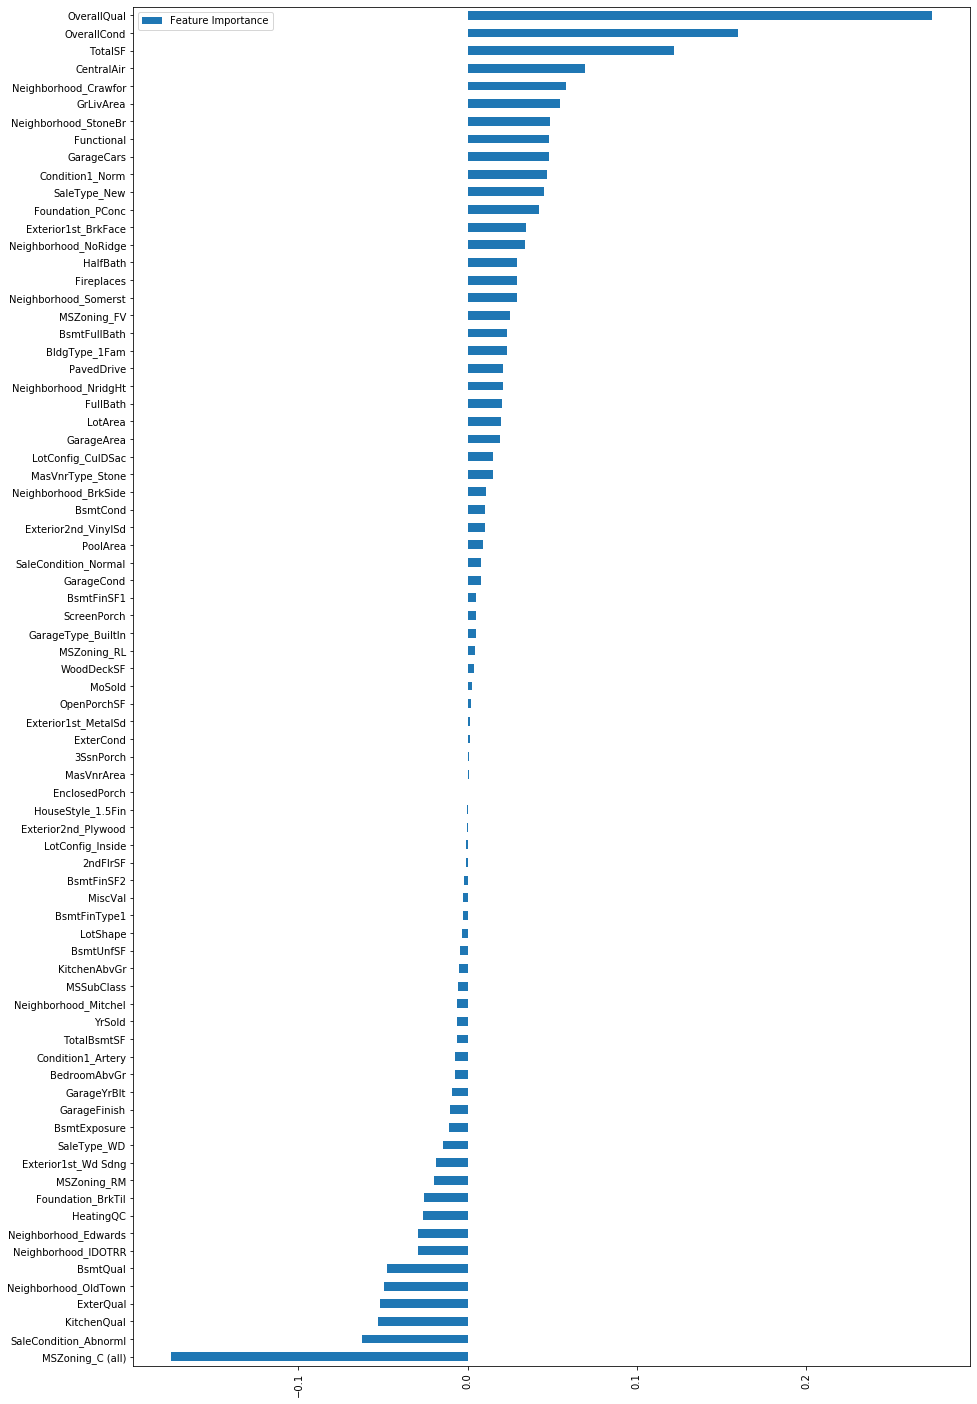

In [52]:
FI_lasso[FI_lasso["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)
plt.show()


In [ ]:
#基礎模型
#定義交叉驗證策略


In [208]:
# cross_val_score默認使用K折交叉驗證策略。此處先使用KFold的shuffle參數混洗數據
# neg_mean_squared_error：負均方誤差，是損失函數，優化目標是使其最小化
n_splits = 5
def nmse_cv(model):
    kf = KFold(n_splits, shuffle=True, random_state=42).get_n_splits(train.values)
    nmse = np.sqrt(-cross_val_score(model, train.values, y_train, scoring='neg_mean_squared_error', cv=kf))
    return(nmse)



In [209]:
#建立基礎模型
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=0.25)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)


In [210]:
#基礎模型分數

models = [lasso, ENet, KRR, GBoost, model_xgb, model_lgb]
names = ['Lasso', 'ELasticNet', 'KernelRidge', 'GradientBoosting', 'Xgboost', 'LGBM']
for model, name in zip(models, names):
    score = nmse_cv(model)
    # 驗證結果返回5個分數，求均值和標準差
    print('{} score:{:.4f} ({:.4f}) \n'.format(name, score.mean(), score.std()))

Lasso score:0.1111 (0.0068) 

ELasticNet score:0.1111 (0.0069) 

KernelRidge score:0.1215 (0.0064) 

GradientBoosting score:0.1180 (0.0085) 

Xgboost score:0.1181 (0.0056) 

LGBM score:0.1171 (0.0064) 



In [211]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    
    def __init__(self, models):
        self.models = models
        
    def fit(self, X, y):
        self.clone_models = [clone(x) for x in self.models]
        for model in self.clone_models:
            model.fit(X, y)
        return self
    
    def predict(self, X):
        predictions = np.column_stack([model.predict(X) for model in self.clone_models])
        return np.mean(predictions, axis=1)

In [212]:
#模型平均分數
averaged_models = AveragingModels(models = [ENet, GBoost, KRR, lasso])
score = nmse_cv(averaged_models)
print('Averaged base models score: {:.4f} ({:.4f}) \n'.format(score.mean(), score.std()))


Averaged base models score: 0.1097 (0.0067) 



In [214]:
averaged_models = AveragingModels(models = [lasso, ENet, KRR, GBoost, model_xgb, model_lgb])
score = nmse_cv(averaged_models)
print('Averaged base models score: {:.4f} ({:.4f}) \n'.format(score.mean(), score.std()))


Averaged base models score: 0.1095 (0.0061) 



In [ ]:
#方法二：模型疊加
#模型疊加類


In [215]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
        
    # 将原来的模型clone出来，并且实现fit功能    
    def fit(self, X, y):
        self.clone_base_models = [list() for x in self.base_models]
        self.clone_meta_model = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        
        # 使用K-fold的方法来进行交叉验证，将每次验证的结果作为新的特征来进行处理
        for i, model in enumerate(self.base_models):
            for train_index, test_index in kfold.split(X, y):
                instance = clone(model)
                self.clone_base_models[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[test_index])
                out_of_fold_predictions[test_index, i] = y_pred
                
        # 将交叉验证预测出的结果(标签)和训练集中的标签值用元模型进行训练
        self.clone_meta_model.fit(out_of_fold_predictions, y)
        return self
        
    def predict(self, X):
        # 得到各模型预测结果平均值的二维数组
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.clone_base_models
        ])
        return self.clone_meta_model.predict(meta_features)


In [216]:
# 额外补充：举例理解column_stack

# a,b代表各个模型预测结果
a = np.array([1,2,3])
b = np.array([4,5,6])
# 将列排成二维数组，即将各个模型对每一个样本的预测结果分别组成一个数组，3行2列
np.column_stack((a,b))

array([[1, 4],
       [2, 5],
       [3, 6]])

In [217]:
# 按列取平均值，即各样本预测结果的平均值，得到一维数组
np.column_stack([a,b]).mean(axis=1)

array([2.5, 3.5, 4.5])

In [218]:
# 将一维数组转化为二维数组，3行1列
np.column_stack([np.column_stack([a,b]).mean(axis=1)])

array([[2.5],
       [3.5],
       [4.5]])

In [ ]:
#模型叠加分数

In [219]:
stacked_averaged_models = StackingAveragedModels(base_models=(ENet, GBoost, KRR), meta_model=lasso)
score = nmse_cv(stacked_averaged_models)
print('Stacking Averaged models score: {:.4f} ({:.4f})'.format(score.mean(), score.std()))
# 结果模型叠加分数比模型平均分数更低，模型效果更好

Stacking Averaged models score: 0.1089 (0.0071)


In [220]:
#定義評估函數
# 均方差：MSE的值越小，預測模型具有更好的精確度
def mse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))


In [ ]:
#模型訓練、預測、評估

In [221]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
# 前面用log1p函數轉化使標籤更加服從高斯分佈，現用expm1將預測出的平滑數據進行還原
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(mse(y_train, stacked_train_pred))

0.08364795949325557


In [222]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(mse(y_train, xgb_train_pred))

0.07948743843071202


In [223]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test))
print(mse(y_train, lgb_train_pred))

0.07378608759360113


In [224]:
# 基于交叉验证分数给出权重
# Xgboost score:0.1161 (0.0079) 
# LGBM score:0.1167 (0.0072) 
# Stacking Averaged models score: 0.1084 (0.0073)
print('MSE score on train data:')
print(mse(y_train, stacked_train_pred*0.70 + xgb_train_pred*0.15 + lgb_train_pred*0.15))

MSE score on train data:
0.07949838298211556


In [225]:
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15
ensemble

array([121933.23547762, 159583.15222991, 186278.08123849, ...,
       167926.23313767, 116516.88511682, 219613.55623276])

In [226]:
sub = pd.DataFrame()
sub['Id'] = test_Id
sub['SalePrice'] = ensemble
sub.to_csv('submit.csv', index=False)